# SEI Growth Asymmetry During Battery Operation
Experimental studies have revealed significant asymmetry in Solid Electrolyte Interphase (SEI) formation between charging and discharging processes in lithium-ion batteries. As shown in Figure 1, Attia et al. (2019) demonstrated through differential capacity analysis that capacity fade during lithiation (charging) significantly exceeds that during delithiation (discharging). Their measurements showed capacity loss during charging can be nearly two orders of magnitude higher than during discharging.

<img src="attia_1.png" alt="Example Figure" style="width:50%; height:auto;"/>

Several mechanisms have been proposed to explain this behavior. The dominant hypothesis suggests that concurrent lithium intercalation and electron availability during charging create favorable conditions for enhanced SEI formation. Mechanical stress from particle expansion during lithiation may also expose fresh electrode surfaces, promoting additional growth.


Most common zero-dimensional SEI models qualitatively capture the charge-discharge asymmetry, with varying accuracy. 
In this notebook, we examine six PyBaMM zero-dimensional SEI models: ("reaction limited","solvent-diffusion limited", "ec reaction limited", "electron-migration limited",   "interstitial-diffusion limited",  "VonKolzenberg2020")


Key Observations from SEI Growth Comparison:

- Effect of decreasing C-rate (C/5 → C/100):
    - Most models: Charge/discharge curves become more symmetric
    - EC reaction-limited: Maintains consistent difference between charge/discharge


These modelling results suggest current models capture key aspects of SEI growth behavior but may not fully represent all physical mechanisms involved in the experimental observations.


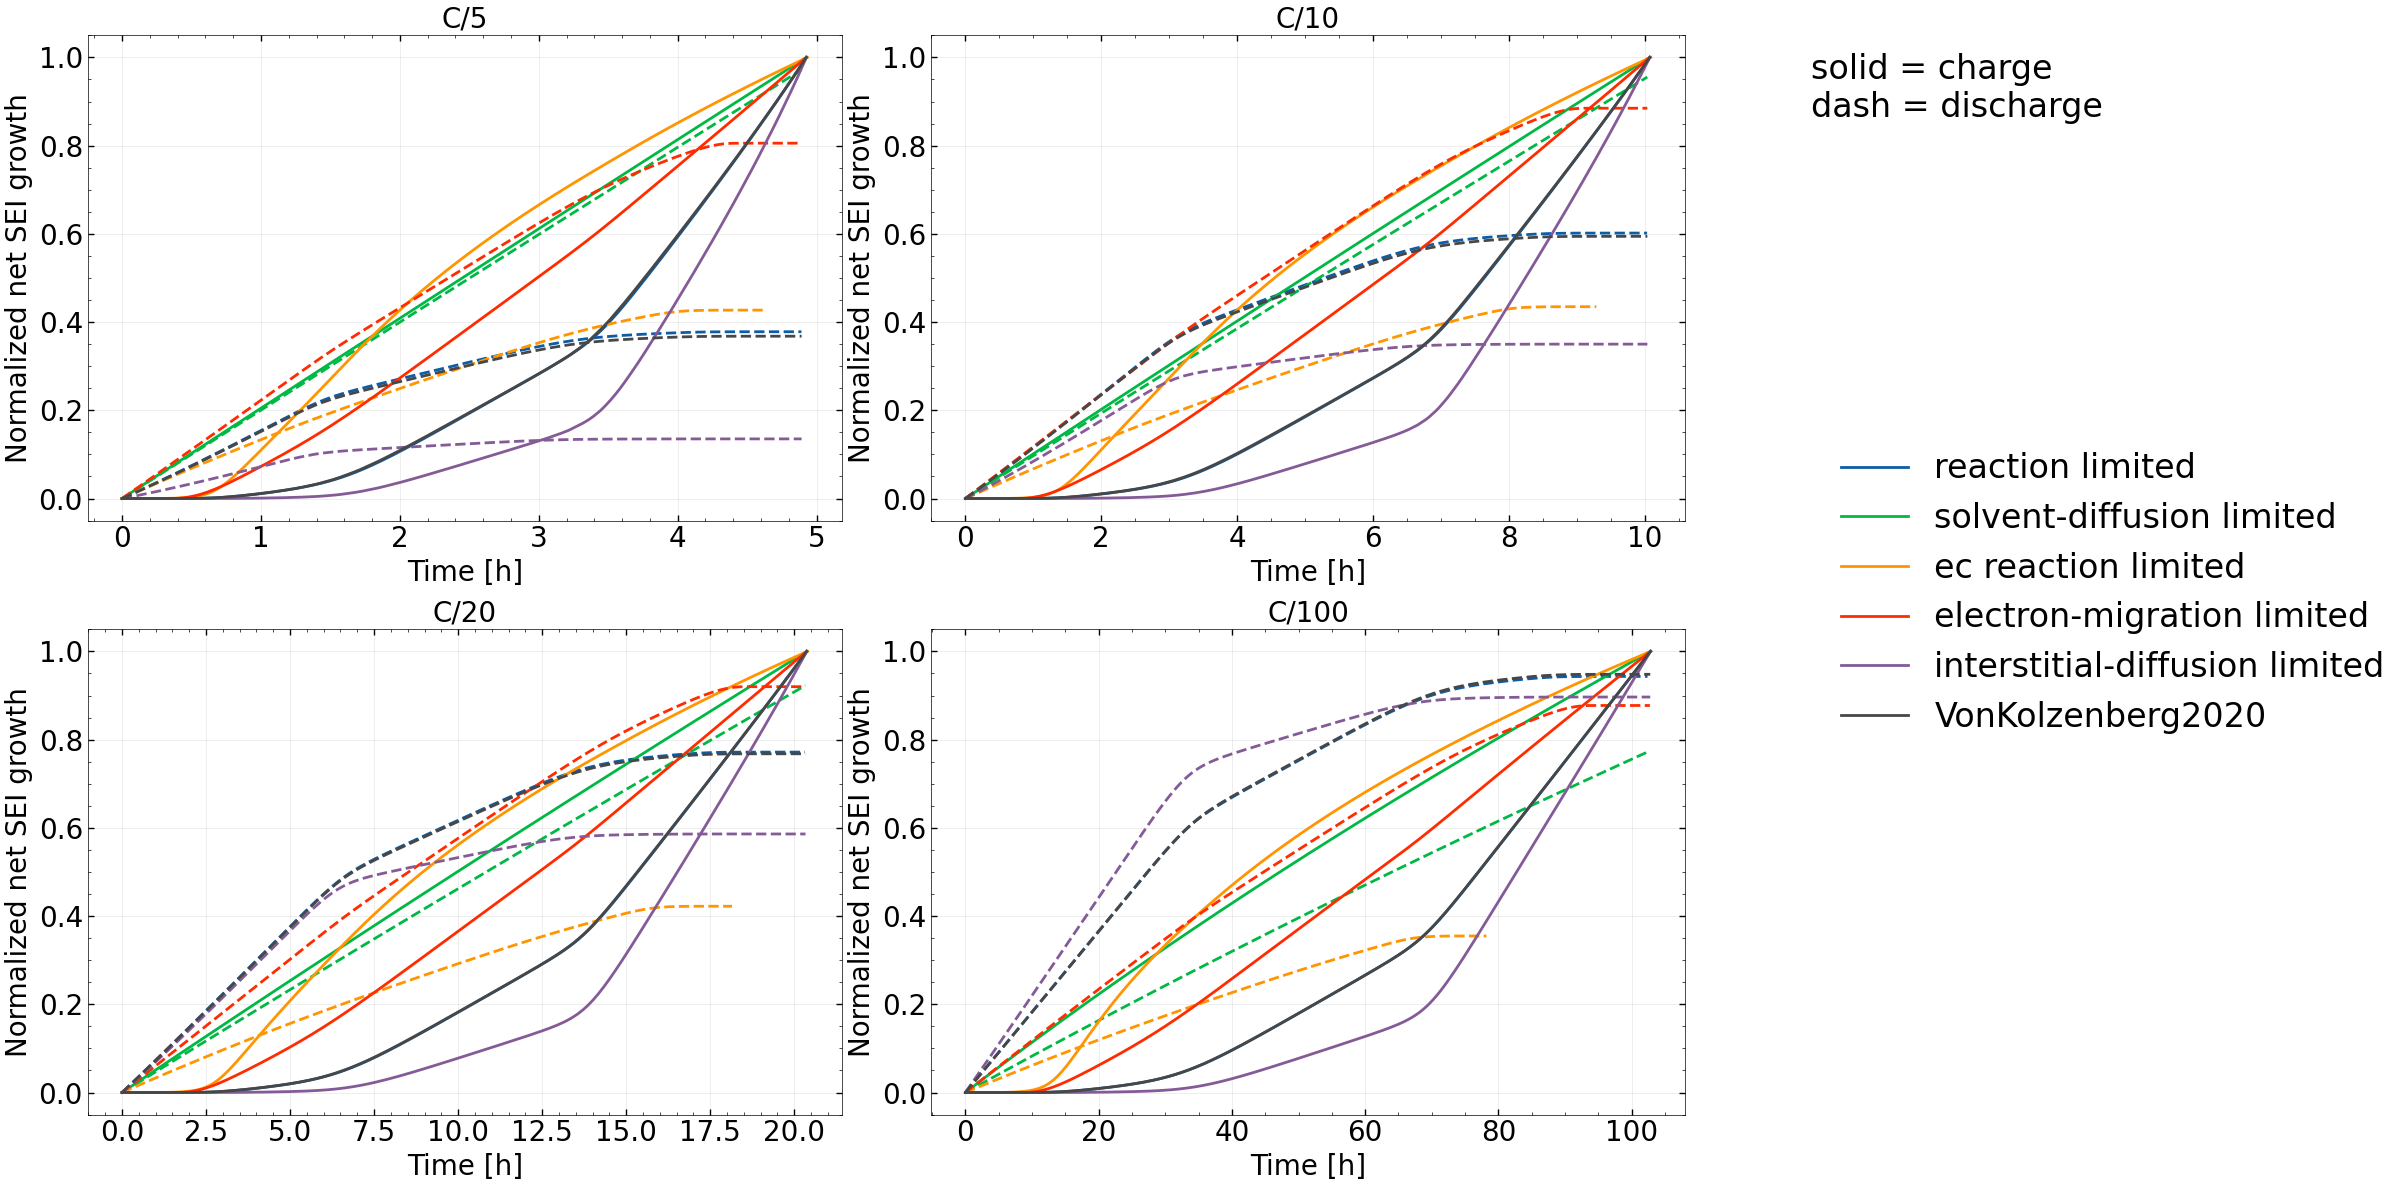

In [47]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
from style_figs import set_plotting_format

# Define the C-rates to test
c_rates = ["C/5", "C/10", "C/20", "C/100"]
no_cycles = 1

# Define SEI options
sei_options = [
    "reaction limited",
    "solvent-diffusion limited",
    "ec reaction limited",
    "electron-migration limited",
    "interstitial-diffusion limited",
    "VonKolzenberg2020",
]

# Define parameter values
param = pybamm.ParameterValues("Chen2020")
param.update({
    'Initial SEI thickness [m]': 5e-9,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Tunneling distance for electrons [m]': 5,
    "SEI resistivity [Ohm.m]": 0,
}, check_already_exists=False)

# Create models for each SEI option
models = [pybamm.lithium_ion.SPM({
    "SEI porosity change": "false",
    "SEI": sei_option
}) for sei_option in sei_options]

# Create a 2x2 subplot figure with extra space for legend
set_plotting_format("paper")
fig, axs = plt.subplots(2, 2, figsize=(18, 12))  # Made figure wider
axs = axs.ravel()  # Flatten the 2x2 array for easier indexing

# Store legend handles and labels
legend_handles = []
legend_labels = []

# Font sizes
AXIS_LABEL_SIZE = 20
TICK_LABEL_SIZE = 20
LEGEND_FONT_SIZE = 24
TITLE_FONT_SIZE = 20

# Loop through each C-rate
for i, c_rate in enumerate(c_rates):
    # Define the experiment for the current C-rate
    exp = pybamm.Experiment([
        (
            f"Charge at {c_rate} until 4.2 V",
            f"Discharge at {c_rate} until 2.5 V",
        )
    ] * no_cycles)

    # Create simulations
    sims = [pybamm.Simulation(model, parameter_values=param, experiment=exp)
            for model in models]

    # Solve for initial SOC = 0
    sols = [sim.solve(initial_soc=0) for sim in sims]

    # Plot normalized SEI thickness for each model
    for index, (sol, sei_option) in enumerate(zip(sols, sei_options)):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][index % len(sei_options)]
        
        for cycle in range(no_cycles):
            # Get time and current data
            t = sol.cycles[cycle]["Time [h]"].entries
            I = sol.cycles[cycle]['Current [A]'].entries
            L_sei = sol.cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries
            
            # Split into charge and discharge
            charge_mask = I < 0
            discharge_mask = I > 0
            
            # Get separate charge and discharge data
            t_charge = t[charge_mask] - t[charge_mask][0]
            t_discharge = t[discharge_mask] - t[discharge_mask][0]
            
            L_sei_charge = L_sei[charge_mask] - L_sei[charge_mask][0]
            L_sei_discharge = L_sei[discharge_mask] - L_sei[discharge_mask][0]
            
            L_sei_max = np.max(L_sei_charge)
            
            if L_sei_max > 0:
                L_sei_charge_norm = L_sei_charge / L_sei_max
                L_sei_discharge_norm = L_sei_discharge / L_sei_max
                
                # Plot curves
                line_charge, = axs[i].plot(t_charge, L_sei_charge_norm,
                                         color=color, linestyle='-', linewidth=2)
                axs[i].plot(t_discharge, L_sei_discharge_norm,
                           color=color, linestyle='--', linewidth=2)
                
                # Only add charge (solid) lines to legend for first subplot
                if i == 0:
                    legend_handles.append(line_charge)
                    legend_labels.append(sei_option)

    # Set labels and title with increased font size
    axs[i].set_xlabel('Time [h]', fontsize=AXIS_LABEL_SIZE)
    axs[i].set_ylabel('Normalized net SEI growth', fontsize=AXIS_LABEL_SIZE)
    axs[i].set_title(f'{c_rate}', fontsize=TITLE_FONT_SIZE)
    axs[i].tick_params(axis='both', labelsize=TICK_LABEL_SIZE)
    axs[i].grid(True, alpha=0.3)

# Create legend
fig.legend(legend_handles, legend_labels, 
          loc='center left', 
          bbox_to_anchor=(1.01, 0.5),  # Reduced spacing between plots and legend
          ncol=1,
          fontsize=LEGEND_FONT_SIZE)

# Add line style note above legend
fig.text(1.01, 0.95, 'solid = charge\ndash = discharge', 
         fontsize=LEGEND_FONT_SIZE, 
         transform=fig.transFigure,
         verticalalignment='top')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.94)  # Adjusted space for legend
plt.savefig("ch_VS_dch_all.png", dpi=300)
plt.show()

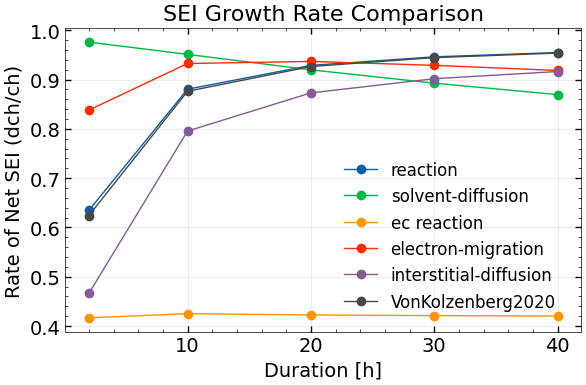

In [48]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
TITLE_FONT_SIZE = 16
AXIS_LABEL_SIZE = 14
TICK_LABEL_SIZE = 14
LEGEND_FONT_SIZE = 12

# Define durations and SEI options

sei_options = [
    "reaction limited",
    "solvent-diffusion limited",
    "ec reaction limited",
    "electron-migration limited",
    "interstitial-diffusion limited",
    "VonKolzenberg2020",
]

# Create figure with specific size for better legend placement
fig, ax = plt.subplots(figsize=(6, 4))

# Store symmetry metrics for all models
all_symmetry_metrics = {model: [] for model in sei_options}

# Calculate and plot symmetry metrics for each model
param = pybamm.ParameterValues("Chen2020")
param.update({
    'Initial SEI thickness [m]': 5e-9,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Tunneling distance for electrons [m]': 5,
}, check_already_exists=False)
durations = [2, 10, 20, 30, 40]
def create_experiment(duration):
    return pybamm.Experiment([
        (
            "Charge at C/2 until 4.1 V",
            f"Charge at C/300 for {duration} hour",
            f"Discharge at C/300 for {duration} hour",
            "Discharge at C/2 until 2.5 V",
        )
    ])
    #  return pybamm.Experiment([
    #     (
    #         "Charge at C/100 until 3.0 V",
    #         f"Charge at C/10 until 4.2 V",
    #         f"Discharge at C/10 until 3.0 V",
    #         "Discharge at C/100 until 2.5 V",
    #     )
    # ])

for sei_option in sei_options:
    model = pybamm.lithium_ion.SPM({"SEI": sei_option})
    symmetry_metrics = []
    
    for duration in durations:
        try:
            exp = create_experiment(duration)
            sim = pybamm.Simulation(model, parameter_values=param, experiment=exp)
            sol = sim.solve(initial_soc=0)
            
            t = sol.cycles[0]["Time [h]"].entries
            I = sol.cycles[0]['Current [A]'].entries
            L_sei = sol.cycles[0]['X-averaged negative total SEI thickness [m]'].entries
            
            charge_mask = I < 0
            discharge_mask = I > 0
            
            if np.any(charge_mask) and np.any(discharge_mask):
                L_sei_charge = L_sei[charge_mask]
                L_sei_discharge = L_sei[discharge_mask]
                
                delta_charge = L_sei_charge[-1] - L_sei_charge[0]
                delta_discharge = L_sei_discharge[-1] - L_sei_discharge[0]
                
                symmetry = delta_discharge / delta_charge
                symmetry_metrics.append(symmetry)
                
        except Exception as e:
            print(f"Error with {sei_option} at duration {duration}h: {str(e)}")
            continue
    
    if symmetry_metrics:
        ax.plot(durations[:len(symmetry_metrics)], symmetry_metrics, 
                'o-', label=sei_option.replace(" limited", ""))

# Customize plot
ax.set_title('SEI Growth Rate Comparison', fontsize=TITLE_FONT_SIZE)
ax.set_xlabel('Duration [h]', fontsize=AXIS_LABEL_SIZE)
ax.set_ylabel('Rate of Net SEI (dch/ch)', fontsize=AXIS_LABEL_SIZE)
ax.tick_params(axis='both', labelsize=TICK_LABEL_SIZE)

# Position legend in bottom right corner with slight padding
ax.legend(loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=LEGEND_FONT_SIZE)
ax.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()